Sources: 

https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101
https://www.jillcates.com/pydata-workshop/html/tutorial.html
https://www.ahoulette.com/2019/03/11/beer-advocate-reviews/
https://notebook.community/mwee/BeerRecommender/Recommender


In [2]:
import scipy
import math
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('beer_reviews.csv')
df.head(5).transpose()

,0,1,2,3,4
index,0,1,2,3,4
brewery_id,10325,10325,10325,10325,1075
brewery_name,Vecchio Birraio,Vecchio Birraio,Vecchio Birraio,Vecchio Birraio,Caldera Brewing Company
review_time,1234817823,1235915097,1235916604,1234725145,1293735206
review_overall,1.50,3.00,3.00,3.00,4.00
review_aroma,2.00,2.50,2.50,3.00,4.50
review_appearance,2.50,3.00,3.00,3.50,4.00
review_profilename,stcules,stcules,stcules,stcules,johnmichaelsen
beer_style,Hefeweizen,English Strong Ale,Foreign / Export Stout,German Pilsener,American Double / Imperial IPA
review_palate,1.50,3.00,3.00,2.50,4.00


# Step 1: EDA

See `beer_eda.ipynb`

Main takeaways:

- Is there bias in the dataset?
    - There are 5,840 breweries and 66,055 beers represented in this dataset. The top breweries are familiar but we were expecting to see Coors, Miller, Budlight etc... These breweries are in the dataset, just not reviewed as much. Good to know the dataset does have a slight bias towards craft beers. 
- How many reviews do beers typically get. Thinking forward about the recsys, we want to depend more on well rounded reviews, rather than a beer that has a great rating, but from only one review. This will help us decide where to cut off the outliers in our data before building the recsys.
    - Looks like most beers dont get many reviews. The median is 2 and mean is 24.
- Does the style of beer matter? Assumption is yes but lets try to prove this with eda. Are certain styles consistent? There are several styles that are very popular and some that are obscure.
    - It seems some of the higher rated beer styles have a lot more reviews than the lower rated beer styles. This correlation is interesting. Although its not linear relationship so we decided to explore the variance within these features.
        - Picking an imperial stout or ipa seems to generate more confidence on how 'good' it is if it were picked. If i pick one of these beers it will most likely be good.
        - Old ale or Gueuze seem to have more variation. If i pick one of these beers, it might be really good or just ok. 
        - The bottom portions seems to have more variance  in the intervals themselves. The top beers ranged about .1 points were the bottom beers are ranging .2 to .3 points. If i pick one of these beers, Im not very sure if it will be any good, or worth drinking. 

# Step 2: Data Cleaning & Prep

### 2.1 Cleanup - Most reviewers don’t review many beers and most beers don’t get reviewed many times. We like a sparse matrix, but we don’t gain a lot of information from reviewers that review one time or beers than are only reviewed one time. We need to only include reviewers and beers above some threshold.

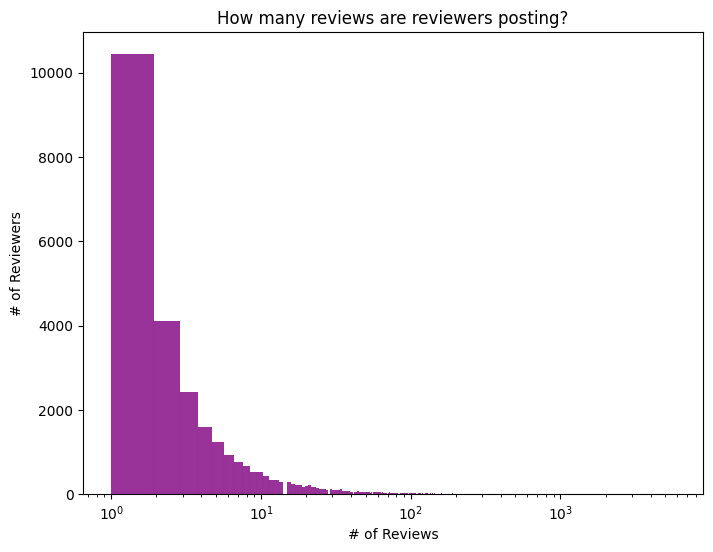

In [4]:
# Count the number of reviews per reviewer
reviews_per_reviewer = (df
                        .groupby('review_profilename')
                        .size()
                        .reset_index(name='n')
                        .sort_values('n', ascending=False))

# create plot
plt.figure(figsize=(8, 6))
sns.histplot(data=reviews_per_reviewer, x='n', color='purple', edgecolor='k', alpha=.8)
plt.xscale('log')
plt.xlabel('# of Reviews')
plt.ylabel('# of Reviewers')
plt.title('How many reviews are reviewers posting?')
plt.show()

In [5]:
# factorizing the beerId and userId for later
df['review_profilename'] = pd.factorize(df['review_profilename'])[0] + 1
df['beer_beerid'] = pd.factorize(df['beer_beerid'])[0] + 1

In [6]:
# filter to reviewers who have reviewed above 50 beers and beers with greater than 100 reviews
over_50 = df.groupby(['review_profilename']).filter(lambda x: len(x) >= 50)
over_50 = over_50.groupby(['beer_beerid']).filter(lambda x: len(x) >= 100)

### 2.2 Pre-processing - We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a “utility” matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn’t require any information about the users or the movies user to generate recommendations

In [7]:
# new df with just username, beer id, and overall review
x_df = over_50[['review_profilename', 'beer_beerid', 'review_overall']]

# rename columns for easy use
x_df.columns = ['userId', 'beerId', 'rating']

x_df.describe()

,userId,beerId,rating
count,948722.00,948722.00,948722.00
mean,2406.58,31539.14,3.86
std,2423.37,19223.88,0.68
min,0.00,7.00,1.00
25%,637.00,14417.00,3.50
50%,1604.00,30590.00,4.00
75%,3352.00,48290.00,4.50
max,19172.00,65906.00,5.00


The create_X() function outputs a sparse matrix X with four mapper dictionaries:

    user_mapper: maps user id to user index
    beer_mapper: maps movie id to movie index
    user_inv_mapper: maps user index to user id
    beer_inv_mapper: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/beer id

In [8]:
# https://www.jillcates.com/pydata-workshop/html/tutorial.html

from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, beerID, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        beer_mapper: dict that maps movie id's to movie indices
        beer_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['beerId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    beer_mapper = dict(zip(np.unique(df["beerId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    beer_inv_mapper = dict(zip(list(range(N)), np.unique(df["beerId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [beer_mapper[i] for i in df['beerId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, beer_mapper, user_inv_mapper, beer_inv_mapper

X, user_mapper, beer_mapper, user_inv_mapper, beer_inv_mapper = create_X(x_df)

In [9]:
# evaluating sparsity
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 6.79%


In [10]:
n_ratings_per_user = X.getnnz(axis=1)

print(f"Most active user rated {n_ratings_per_user.max()} beers.")
print(f"Least active user rated {n_ratings_per_user.min()} beers.")

Most active user rated 2266 beers.
Least active user rated 4 beers.


In [11]:
n_ratings_per_beer = X.getnnz(axis=0)

print(f"Most rated beer has {n_ratings_per_beer.max()} ratings.")
print(f"Least rated beer has {n_ratings_per_beer.min()} ratings.")

Most rated beer has 2314 ratings.
Least rated beer has 96 ratings.


C:\Users\epwol\AppData\Local\Temp\ipykernel_14396\917671282.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
C:\Users\epwol\AppData\Local\Temp\ipykernel_14396\917671282.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_beer, shade=True)


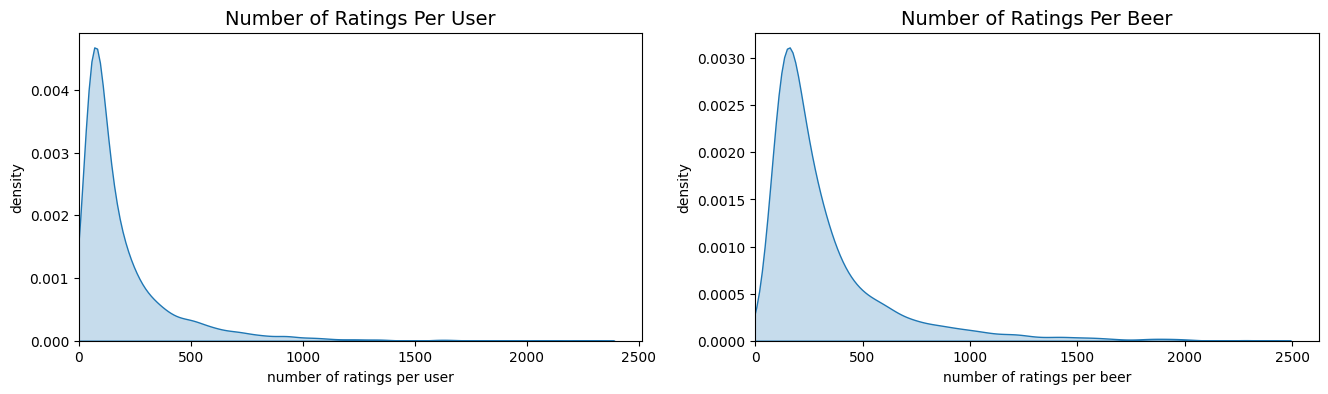

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_beer, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Beer", fontsize=14)
plt.xlabel("number of ratings per beer")
plt.ylabel("density")
plt.show()

### 2.3 Normalize the Data

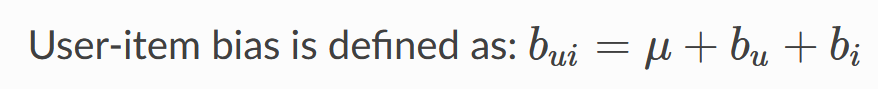 

We will perform mean normalization by subtracting b*i* from each beer's rating.

In [13]:
sum_ratings_per_beer = X.sum(axis=0)
mean_rating_per_beer = sum_ratings_per_beer/n_ratings_per_beer

Now that we have the mean rating for each beer, we are going to subtract this from our utility matrix. In order to do this, we need to expand our 1D `mean_rating_per_beer` array into a matrix with the same shape as our utility matrix `(n_users, n_beers)`. Numpy’s `tile` method is useful for this task.

In [14]:
X_mean_beer = np.tile(mean_rating_per_beer, (X.shape[0],1))
X_mean_beer.shape

(4787, 2883)

`X_mean_beer` is a matrix of shape (n_users, n_beers) in which each column is populated with a given beer's mean rating.

We can easily normalize our X matrix by subtracting `X_mean_beer` from original X

In [15]:
X_norm = X - csr_matrix(X_mean_beer)
print("Original X:", X[0].todense())
print("Normalized X:", X_norm[0].todense())

Original X: [[0. 0. 0. ... 0. 0. 0.]]
Normalized X: [[-2.63979849 -3.99677419 -4.04782609 ... -4.08389262 -3.85344828
  -4.04746835]]


As expected, `X_norm’s` values are different from `Xs`. Cells that are empty in the original matrix are now replaced with negative values representing the mean rating of a given beer

# Step 3: Item-item Recommendations with k-Nearest Neighbors
We are going to find the k beers that have the most similar user engagement vectors for beer i.

In [30]:
# We are going to find the k beers that have the most similar user engagement vectors for beer i

from sklearn.neighbors import NearestNeighbors

def find_similar_beers(beerId, X, beer_mapper, beer_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given beer id.

    Args:
        movie_id: id of the beer of interest
        X: user-item utility matrix
        k: number of similar beer to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar beer ID's
    """
    X = X.T
    neighbour_ids = []

    beer_ind = beer_mapper[beerId]
    beer_vec = X[beer_ind]
    if isinstance(beer_vec, (np.ndarray)):
        beer_vec = beer_vec.reshape(1,-1)
    # use k+1 since kNN output includes the beerID of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(beer_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(beer_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [17]:
beer_names = dict(zip(df['beer_beerid'], df['beer_name']))

beer_id = 7

similar_beers = find_similar_beers(beer_id, X_norm, beer_mapper, beer_inv_mapper, metric='cosine', k=10)
beer_name = beer_names[beer_id]

print(f"Because you tried {beer_name}:")
for i in similar_beers:
    print(beer_names[i])

Because you tried Amstel Light:
Foster's Special Bitter
Anheuser World Lager
Molson Ice
Molson Golden
Milwaukee's Best Light
Red Dog
Keystone Ice
Presidente
Famosa (Gallo)


Note that these recommendations are based solely on user-item ratings. Beer features such as genres are not used in this approach. We also played around with the kNN distance metric and see what results you would get if you use “manhattan” or “euclidean” instead of “cosine”.

In [18]:
similar_beers = find_similar_beers(beer_id, X_norm, beer_mapper, beer_inv_mapper, metric='manhattan', k=10)
beer_name = beer_names[beer_id]

print(f"Because you tried {beer_name}:")
for i in similar_beers:
    print(beer_names[i])

Because you tried Amstel Light:
Michelob Ultra Amber
Heineken Premium Light Lager
Miller Genuine Draft Light 64
Colt 45 Malt Liquor
O'Doul's
Milwaukee's Best Light
Hurricane High Gravity Lager
Michelob Honey Lager
Steel Reserve 211 (High Gravity)


In [19]:
similar_beers = find_similar_beers(beer_id, X_norm, beer_mapper, beer_inv_mapper, metric='euclidean', k=10)
beer_name = beer_names[beer_id]

print(f"Because you tried {beer_name}:")
for i in similar_beers:
    print(beer_names[i])

Because you tried Amstel Light:
Red Dog
Milwaukee's Best Light
Famosa (Gallo)
O'Doul's
Milwaukee's Best Ice
Michelob Honey Lager
Keystone Ice
Molson XXX
Labatt Blue Light


# Step 4: Cold Start Problem
Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the cold start problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features


In [20]:
n_beers = df['beer_beerid'].nunique()
print(f"There are {n_beers} unique beers in our dataset.")
n_styles = df['beer_style'].nunique()
print(f"There are {n_styles} unique beer styles in our dataset.")


There are 66055 unique beers in our dataset.
There are 104 unique beer styles in our dataset.


In [21]:
beer_styles = df[['beer_beerid', 'beer_style', 'beer_name']]
beer_styles.drop_duplicates(inplace=True)
beer_styles.columns = ['beerId', 'beerStyle', 'beerName']
beer_styles

C:\Users\epwol\AppData\Local\Temp\ipykernel_14396\3132472177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beer_styles.drop_duplicates(inplace=True)


,beerId,beerStyle,beerName
0,1,Hefeweizen,Sausa Weizen
1,2,English Strong Ale,Red Moon
2,3,Foreign / Export Stout,Black Horse Black Beer
3,4,German Pilsener,Sausa Pils
4,5,American Double / Imperial IPA,Cauldron DIPA
...,...,...,...
1586594,66051,American Porter,Highland Porter
1586595,66052,Hefeweizen,Baron Von Weizen
1586596,66053,Belgian Strong Pale Ale,Resolution #2
1586599,66054,American Double / Imperial IPA,Double IPA


In [32]:
styles = beer_styles.drop(columns=['beerId', 'beerName'])
styles = pd.get_dummies(styles).reset_index()
styles = styles.drop(columns=['index'])
styles.transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,66045,66046,66047,66048,66049,66050,66051,66052,66053,66054
beerStyle_Altbier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
beerStyle_American Adjunct Lager,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
beerStyle_American Amber / Red Ale,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
beerStyle_American Amber / Red Lager,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
beerStyle_American Barleywine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(styles, styles)
print(f"Dimensions of our styles cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our styles cosine similarity matrix: (66055, 66055)


In [24]:
def beer_finder(style):
    return beer_styles[beer_styles['beerStyle'].str.contains(style)]['beerStyle'].tolist()

def get_similar_by_style(beer_style):
    beer_idx = dict(zip(beer_styles['beerStyle'], list(styles.index)))
    style = beer_finder(beer_style)[0]
    n_recommendations = 10

    idx = beer_idx[style]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_beers = [i[0] for i in sim_scores]

    print(f"Recommendations for {style}:")
    return beer_styles['beerName'].iloc[similar_beers]

In [25]:
get_similar_by_style('American Porter')

Recommendations for American Porter:


403                The Captain's Porter
725                      Coconut Porter
899                               Mogli
934                         Orca Porter
1538                       Viven Porter
1656                       Monon Porter
1677    Jack Daniels Barrel Aged Porter
1703                             Porter
1758                       Bjava Porter
1974         Little Chocolate Doughnuts
Name: beerName, dtype: object

In [26]:
get_similar_by_style('IPA')

Recommendations for American Double / Imperial IPA:


918                        Holiday Imperial
1284                  Ballz Deep Double IPA
1695                    Hopcicle Double IPA
1858                    Oatboy Imperial IPA
1981                     Viven Imperial IPA
2217    Professor Gesser's Mind Numbing Ale
2361                           NoDa Rye Z'd
2419                       Hoppocratic Oath
2537                    Hopturnal Emissions
2565                        Pike Double IPA
Name: beerName, dtype: object

With this approach, we are assuming that two beers are “similar” if they have similar beer styles. These “similar beer recommendations are based solely on the metadata from our dataset. 

# Step 5: Dimensionality Reduction with Matrix Factorization
 Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and items. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

    user-factor matrix (n_users, k)
    item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into “taste” dimensions. We cannot interpret what each latent feature k represents. However, we could imagine that one latent feature may represent users who like hoppy beers, while another latent feature may represent beers that have some unique aroma or color. 


In [27]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Z = svd.fit_transform(X.T)

beer_id = 7
sim_beers = find_similar_beers(beer_id, Z.T, beer_mapper, beer_inv_mapper, metric='cosine', k=10)
beer_name = beer_names[beer_id]

print(f"Because you tried {beer_name}:")
for i in sim_beers:
    print(beer_names[i])

Because you tried Amstel Light:
Michelob Ultra
Rolling Rock Extra Pale
Dos Equis Amber Lager
Michelob Amber Bock
Harp Lager
Foster's Lager
Michelob (Original Lager)
Peroni Nastro Azzurro
St. Pauli Girl


The results above are the most similar beers to Amstel Light using kNN on our “compressed” beer-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as beer style!

With matrix factorization, we can also predict missing ratings in our original user-item matrix. We can do this by reconstructing our matrix by getting the inner product of our user-factor matrix and beer-factor matrix. We can use the inverse_transform on our beer-factor matrix Z to get our reconstructed user-item matrix.

In [28]:
new_X = svd.inverse_transform(Z).T

#Let’s look at userId=100’s recommendations. In the table below, we can see which beers that have been rated highly
userId = 100

# new df with just username, beer id, and overall review
z_df = over_50[['review_profilename', 'beer_beerid', 'beer_name', 'review_overall']]

# rename columns for easy use
z_df.columns = ['userId', 'beerId', 'beerName', 'rating']

user_preferences = z_df[(z_df['userId']==userId)&(z_df['rating']>=4)]
user_preferences.sort_values('rating', ascending=False).head(10)

,userId,beerId,beerName,rating
484274,100,19145,Cantillon Blåbær Lambik,5.00
1445019,100,60575,Mirror Pond Pale Ale,5.00
453671,100,17907,Unplugged Bohemian Lager,5.00
718083,100,27425,Trumer Pils,5.00
1134796,100,47061,Pliny The Elder,5.00
577259,100,22301,Velvet Merlin (Merkin),5.00
1133425,100,47061,Pliny The Elder,5.00
1443623,100,60629,Jubelale,5.00
1323979,100,53089,Anchor Steam Beer,5.00
1167963,100,48285,Festina Pêche,5.00


Now, let’s take a look at which beers we predict userId=100 will like based on their previous ratings. We will need get the row which represents userId=100 and sort their predicted ratings in descending order. np.argsort() is a useful method for getting the top N indices (i.e., beers with highest rating predictions) for userId=100.

In [29]:
top_N = 10

top_N_indices = new_X[user_mapper[userId]].argsort()[-top_N:][::-1]

print(f"Top {top_N} Recommendations for UserId {userId}:")
for i in top_N_indices:
    beer_id = beer_inv_mapper[i]
    print(beer_names[beer_id])

Top 10 Recommendations for UserId 100:
Supplication
Temptation
Pliny The Elder
Weihenstephaner Hefeweissbier
Consecration
Blind Pig IPA
The Abyss
Sculpin India Pale Ale
Pliny The Younger
Sanctification


# Evaluation

How do we know if our recommendations are good? The best way would be to get direct feedback from users - however that isnt really applicable here. 

Here we generate our training set by masking random interactions in our user-item matrix. In other words, we pretend that we don’t if a user liked or hated beer X, but we actually do. Once we train our model and generate our rating predictions, we can then compare our predicted rating with the actual rating...